In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [10]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import tensorflow as tf
import os

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 전처리 
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)
    
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]

    word_to_index = {word:index for index, word in enumerate(vocab)}
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2  # unknown
    word_to_index["<UNUSED>"] = 3
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 


print('a')

a


In [11]:

index_to_word = {index:word for word, index in word_to_index.items()}
word_to_index["<PAD>"]

0

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


In [12]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))
print(X_train[0])
print(X_test[0])

print(len(X_train[0]))
print(index_to_word[20])


print(get_decoded_sentence(X_train[0], index_to_word))

print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print(get_decoded_sentence)


훈련 샘플 개수: 146182, 테스트 개수: 49157
[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
[832, 130]
10
나
더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0
<function get_decoded_sentence at 0x7fd140628160>


In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


# 데이터 분석 및 가공

In [13]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.reshape)
print(X_test.shape)

<built-in method reshape of numpy.ndarray object at 0x7fd112d22930>
(49157, 41)


In [14]:
vocab_size = len(word_to_index)  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

# model 설계 
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='softmax'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,897
Trainable params: 160,897
Non-trainable params: 0
_________________________________________________________________


In [23]:
# 검증

# validation set 10000건 분리
x_val = X_train[:90000]   
y_val = y_train[:90000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[90000:]  
partial_y_train = y_train[90000:]

print(len(X_train))
print(partial_x_train.shape)
print(partial_y_train.shape)

146182
(56182, 41)
(56182,)


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
110/110 [==============================] - 3s 12ms/step - loss: 0.0991 - accuracy: 0.4980 - val_loss: 0.6567 - val_accuracy: 0.4985
Epoch 2/10
110/110 [==============================] - 1s 8ms/step - loss: 0.0910 - accuracy: 0.4980 - val_loss: 0.6979 - val_accuracy: 0.4985
Epoch 3/10
110/110 [==============================] - 1s 8ms/step - loss: 0.0854 - accuracy: 0.4980 - val_loss: 0.7466 - val_accuracy: 0.4985
Epoch 4/10
110/110 [==============================] - 1s 8ms/step - loss: 0.0852 - accuracy: 0.4980 - val_loss: 0.7476 - val_accuracy: 0.4985
Epoch 5/10
110/110 [==============================] - 1s 8ms/step - loss: 0.0820 - accuracy: 0.4980 - val_loss: 0.7854 - val_accuracy: 0.4985
Epoch 6/10
110/110 [==============================] - 1s 8ms/step - loss: 0.0799 - accuracy: 0.4980 - val_loss: 0.7784 - val_accuracy: 0.4985
Epoch 7/10
110/110 [==============================] - 1s 8ms/step - loss: 0.0779 - accuracy: 0.4980 - val_loss: 0.8212 - val_accuracy: 0.4985
Epoch

In [34]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.9143 - accuracy: 0.5027
[0.9142842888832092, 0.5026954412460327]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


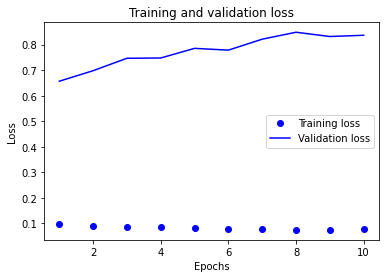

In [35]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목


acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



이포크 5 정도면 적당하려나 

In [30]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 5로 수정

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
110/110 [==============================] - 3s 12ms/step - loss: 0.1162 - accuracy: 0.4980 - val_loss: 0.5835 - val_accuracy: 0.4985
Epoch 2/5
110/110 [==============================] - 1s 8ms/step - loss: 0.1077 - accuracy: 0.4980 - val_loss: 0.6027 - val_accuracy: 0.4985
Epoch 3/5
110/110 [==============================] - 1s 8ms/step - loss: 0.1043 - accuracy: 0.4980 - val_loss: 0.6296 - val_accuracy: 0.4985
Epoch 4/5
110/110 [==============================] - 1s 8ms/step - loss: 0.1050 - accuracy: 0.4980 - val_loss: 0.6427 - val_accuracy: 0.4985
Epoch 5/5
110/110 [==============================] - 1s 8ms/step - loss: 0.0968 - accuracy: 0.4980 - val_loss: 0.6654 - val_accuracy: 0.4985


In [31]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7458 - accuracy: 0.5027
[0.7458018064498901, 0.5026954412460327]


In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
vocab_size = len(word_to_index)  
word_vector_dim = 4    # 위 그림과 같이 4차원의 워드 벡터를 가정합니다. 

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# Embedding 레이어를 적용합니다.
# raw_inputs = np.array(get_encoded_sentences(X_train, word_to_index), dtype='object')

raw_inputs = np.array(get_encoded_sentences(X_train[0], word_to_index), dtype='object')
raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
output = embedding(raw_inputs)
print(output)


print(raw_inputs)

# ========================



In [ ]:
vocab_size = len(word_to_index)  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

In [ ]:
#값을 열어보니 특수문자도 많고 빈 값도 많았다..  정규표현식으로 걸러줘야 하나
import re

a= {3: '', 4: '.', 5: '영화', 6: '다2', 7: '스틸러', 
    8: '하', 9: '♡♡♡♡', 10: 'cm', 11: '..'}
b={}
for idx in a:
#     print(a[idx])
    regex = re.compile('[^가-힣+]')
    result = regex.sub('',a[idx])
    if not result=='':
        b[idx] = result
    else:
        pass
    
print(b)


    
    


In [ ]:
"""
회고 
RNN 사용법은 과 패딩 개념은 알겠는데
코드를 어떻게 짜야 어떤부분을 수정해야 정확히 모르겠다....
내가 부족한건지 다시 처음부터 코드를 짜봐야겠다
요즘 너무 많은것을 머리속에 넣으려고 해서 그런가 머리가 터질거같다 ㅠㅠ
"""